HEADER BAR DOES NOT WORK WITH QUARTO, ACCESS OTHER TABS BY CLOSING THIS ONE

## What is SVM and How Does It Work?

SVM, or support vector machines, is a supervised machine learning algorithm which can analyze data for classification and/or regression, however the subject of the subsequent analysis will involve SVC, or support vector classifiers. The overarching goal of the use of SVM classification is to separate one set of data into two groups by finding a hyperplane (A.K.A. a decision boundary) such that one class of objects is on one side of the boundary, and the other is on the opposing side while minimizing incorrect classifications. It is important to note that SVMs are bianry classifiers by nature, meaning that individually, an application of SVM can only be used to separate a set of data as being part of one group or another (rather than a set of three or more groups being the basis). The ideal outcome of an SVM-based analysis is the discovery of a hyperplane that maximizes the "margin", or the distance between the resulting hyperplane and the support vectors (i.e., nearby observations).

One of the most important parts of SVM are the aptly named "support vectors", which are the points that are near the to-be-determined decision boundary. These points hold the most influence and sway over where exactly the hyperplane that attempts to classify the set of data points will manifest. The SVM algorithm then assesses these data points (along with all others), and computes a decision boundary based on a set of hyperparameters (i.e., user defined inputs) which are discussed in more depth later on in this section. There are several advantages that SVM models have, such as the ability to deal effectively with high dimensional data (for example, words in a text data set such as this analysis deals with) and low sample sizes, along with being very versatile given its varied hyperparameters, and is relatively computationally efficient given its heavy reliance on support vectors (which are a subset of the overall data set). However, SVMs are notoriously suspect to overfitting, where the decision boundary may be extremely accurate for a training data set, but is not generalizable because the generated hyperplane is way too specific. This makes the process of hyperparameter tuning even more vital when constructing an SVM-based model.

The subsequent analysis asessess sentiment analysis labels of tweets (as also explored in the Naive Bayes section) as "positive" or "negative", so this is purely a binary classification problem. In the coming analyses, an SVC based model will be constructed in comparison to a random, simple probability-based model based on the number of "positives" and "negatives" inherent within the already-labelled tweets. It is important to note that these labelled tweets have already been pre-processed to an extent as outlined in the Data Cleaning section, where stop words and other redundant/irrelevant characters and words were removed from the tweets, along with stemming and lemmitization to standardize words of different forms but similar roots (e.g., play, plays, played, playing all have the same root of play). This in and of itself functiosn as a form of feature selection for the subsequent model construction. 

## Feature Selection/Data Processing

Firstly, relevant packages and libraries are loaded in the code drop down below.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
import sklearn
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
import re
import math
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score
import nltk
from nltk.corpus import stopwords
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
nltk.download('words')
from sklearn.model_selection import GridSearchCV

[nltk_data] Downloading package words to
[nltk_data]     C:\Users\alexp\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!


Secondly, the previously cleaned tweets are imported and neutral tweets are dropped as they are not relevant to the analysis.

In [2]:
df = pd.read_csv('../../data/01-modified-data/NYCT-Opinion-Tweets-Sentiments.csv')
# Remove neutral tweets
df = df[df['category']!="neu"]

The subsequent two code chunks convert the data frame of tweets into a format that can be used to create appropriate classification models. Firstly, the set of tweets is converted into a list, and their accompanying sentiment labels are assigned a numeric value (0 for negative, 1 for positive), and converted to a numpy array. Secondly, the tweets themselves are "vectorized" using the CountVectorizer method in which the text is broken up into words. It is important to note that in prior data cleaning, stop words and redundant characters and words were removed, which functions as a form of feature selection. Additionally, feature selection is achieved as words that appear in very few of the tweets are not considered in this analysis (given by the min_df=0.001 argument in CountVectorizer), ensuring that words that have very little impact or relevance to the overall analysis are removed, thus improving the runtime of the subsequent models. These sets of words are then combined into a one-hot encoded document term frequency matrix where each row represents a "document" (in this case tweet), and columns represents the presence of words in each document. Finally, the data is now ready to be further analyzed and models may now be built.

In [3]:
# Convert df to list of strings
corpus = df['text'].tolist()

# Assign numerical codes to categories
df['category'] = pd.Categorical(df['category'])
df['label'] = df['category'].cat.codes
y1 = df['label'].to_numpy()
labels = ['neg','pos']

In [4]:
# Vectorize corpus text
vec = CountVectorizer(min_df=0.001)
all_x = vec.fit_transform(corpus)
X=np.array(all_x.todense())

# one hot encoding
max_x=np.max(X,axis=0)
X=np.ceil(X/max_x)

## Class Distribution

The distribution of positive and negative labels is generated and outputted by the code chunk below. Although the label of "positive" and "negative" have been converted into numeric form, we can see that they are not too different in number, indicating that there is generally a good amount of class balance between the labels. This means that resulting models are less likely to suffer from overfitting (which would occur if one sentiment label was overpresent relative to the other),and thus resulting models can be more generalizable. The relatively balanced nature of the classes for this model indicates that the larger class is likely to be "overclassified," where the smaller class gets overwhelmed by the presence of a larger class in comparison. Ultimately, this is a good indicator for the creation of the subsequent model construction.

In [5]:
print(df['label'].value_counts())

1    273
0    208
Name: label, dtype: int64


## Baseline Model Construction

Before any analysis and model construction occurs, the overall data set of tweets must be split into a training and test set, which in this case is split in an 80%-20% fashion. To provide a baseline to which an SVM model will be compared to, a model based on the prior frequencies/probabilities of positive and negative sentiment labels within the training data. Using these probabilities (i.e., proportion of training tweets with a "positive" label and the proportion with a "negative" label), predictions of sentiment labels were randomly assigned with no regard for the word composition of the tweets. Subsequently, various measures of model fit, such as accuracy, precision, and recall scores, are calculated, displayed, and interpreted below. Additionally, confusion matrices showing the number of correctly and incorrectly predicted sentiment labels are displayed below, where entries in the top left and bottom right indicate the number of correctly labelled tweets.

In [6]:
from sklearn.model_selection import train_test_split
test_ratio=0.2
x_train, x_test, y_train, y_test = train_test_split(X, y1, test_size=test_ratio, random_state=0)
y_train=y_train.flatten()
y_test=y_test.flatten()

CLASSIFICATION REPORT FOR TRAINING SET
              precision    recall  f1-score   support

         neg       0.43      0.45      0.44       169
         pos       0.55      0.53      0.54       215

    accuracy                           0.49       384
   macro avg       0.49      0.49      0.49       384
weighted avg       0.50      0.49      0.50       384

CLASSIFICATION REPORT FOR TEST SET
              precision    recall  f1-score   support

         neg       0.46      0.49      0.48        39
         pos       0.64      0.62      0.63        58

    accuracy                           0.57        97
   macro avg       0.55      0.55      0.55        97
weighted avg       0.57      0.57      0.57        97



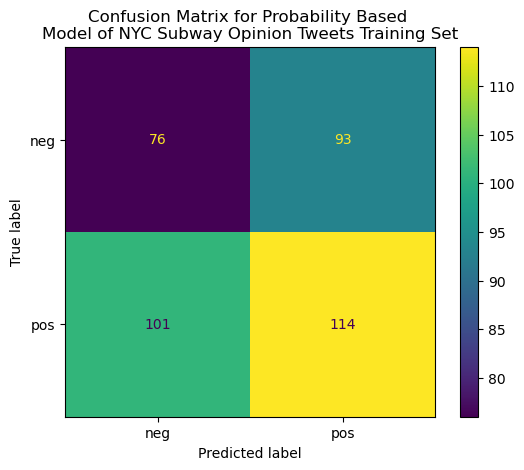

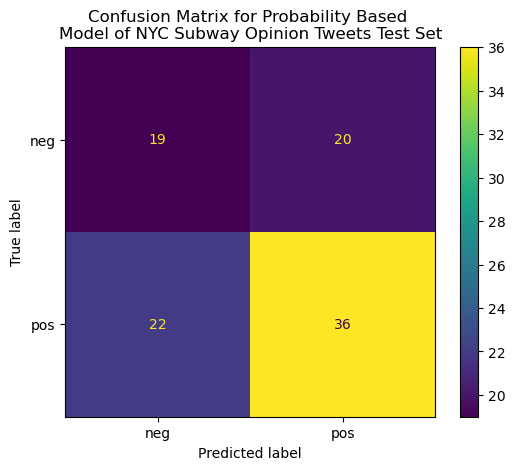

In [7]:
# Model determined by probabilities of positive and negative in the training data
# proability of negative opinion in training data set
p_neg_train = len(y_train[y_train==0])/len(y_train)
#print(p_neg_train)
# Randomly drawn array from uniform distribution based on above probability that serves as a prediction
yp_train = np.random.choice(np.arange(0,2),p=[p_neg_train,1-p_neg_train],size=len(y_train))

# Predict based on same probability for test data set
yp_test = np.random.choice(np.arange(0,2),p=[p_neg_train,1-p_neg_train],size=len(y_test))

# Training set
cm = confusion_matrix(y_train,yp_train)
cm_plot = ConfusionMatrixDisplay(cm,display_labels=labels)
cm_plot.plot()
plt.title("Confusion Matrix for Probability Based \nModel of NYC Subway Opinion Tweets Training Set")
plt.savefig("../../501-project-website/images/SVM-CONFUSION-MX-PBased-train-Opinion-Tweets.png")

# Test set
cm = confusion_matrix(y_test,yp_test)
cm_plot = ConfusionMatrixDisplay(cm,display_labels=labels)
cm_plot.plot()
plt.title("Confusion Matrix for Probability Based \nModel of NYC Subway Opinion Tweets Test Set")
plt.savefig("../../501-project-website/images/SVM-CONFUSION-MX-PBased-test-Opinion-Tweets.png")

# Print classification report
print("CLASSIFICATION REPORT FOR TRAINING SET")
print(classification_report(y_train,yp_train,target_names=["neg","pos"]))
print("CLASSIFICATION REPORT FOR TEST SET")
print(classification_report(y_test,yp_test,target_names=["neg","pos"]))

The above probability-based model is clearly a poor classifier of the sentiments of the MTA-related tweets given by the poor accuracy, precision, and recall scores across the board (all in and around 50%, or not much better than flipping a coin to classify). This is not surprising considering that predictions for this model are entirely random, based on the existing proportions of positive and negative labelled tweets in the training data set. Thus, a more complex and specific model must be used to classify these tweets, so I will build a Support Vector Classifier (SVC) model and analyze its effectiveness compared to the probability-based model constructed above.

## C, Gamma, Kernel Hyperparameter Tuning

However, in order to find the optimal SVC model to classify the MTA-related tweets, there are certain hyperparameters (i.e., user-defined inputs) that affect how a given SVC model fits a given set of data.  Hyperparameters are independent of any training/validation/test data set, and must be determined by the individual constructing a given model. For the SVC type of model, these hyperparameters/choics are C, Gamma, and the kernel. Firstly, the C hyperparameter controls to what extent the model tries to avoid misclassifying observations, with a larger C value leading to the model to try to correctly classify more points, which leads to the risk of overfitting. However, a C parameter that is too low will lead to the resulting model having low accuracy and high rates of misclassification. The kernel choice determines what type of mathematical function the SVC model uses to find its resulting decision hyperplane. Different sets of data may be classified more effectively with differing types of functiosn as their baseline, which indicates that investigating models with differing kernel choices is necessary to find an optimal model. Finally, the gamma parameter essentially controls the curvature of the constructed decision hyperplane, with a high gamma enabling the SVC model to have a more curved decision barrier. This gamma parameter is only truly relevant for RBF (radial basis function) SVC models.

In order to investigate what set of parameters is most optimal for classifying the sentiments of the MTA-related tweets cleaned and explored in prior sections of this project, many combinations of these three parameters must be tested. To do this, I will perform a grid search where models are systematically constructed with differing combinations of parameters and their respective measures of accuracy, precision, etc. are internally calculated. The code that accomplishes this process can be found below.


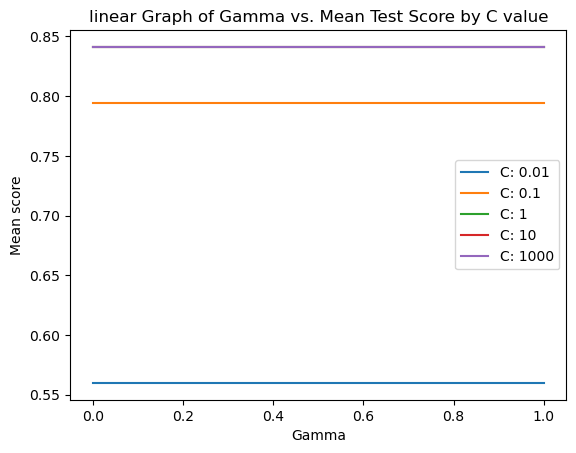

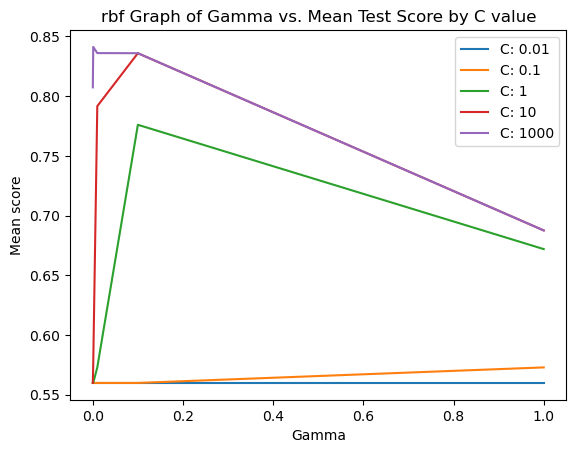

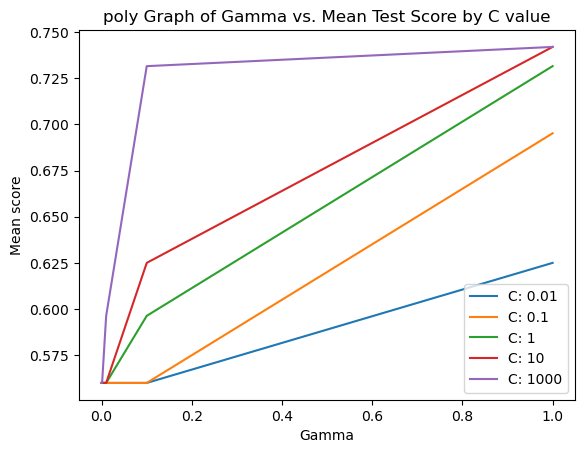

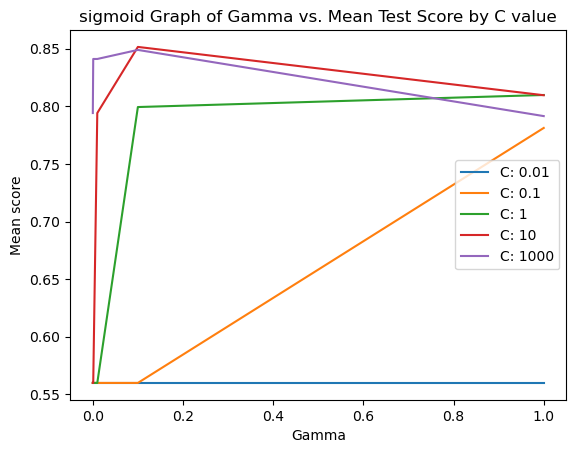

In [8]:
kernel_list = ['linear','rbf', 'poly', 'sigmoid']
Cs = [0.01,0.1,1,10,1000]
gammas = [1,0.1,0.01,0.001,0.0001]
for kernel in kernel_list:
    # Code adapted from https://www.vebuso.com/2020/03/svm-hyperparameter-tuning-using-gridsearchcv/
    param_grid = {'C': Cs, 'gamma': gammas}
    grid = GridSearchCV(SVC(kernel=kernel),param_grid,refit=True)
    grid.fit(x_train,y_train)
    grid_predictions = grid.predict(x_test)
    # Plot of grid search results
    # Code adapted from https://stackoverflow.com/questions/37161563/how-to-graph-grid-scores-from-gridsearchcv

    scores = grid.cv_results_['mean_test_score']
    scores = np.array(scores).reshape(len(Cs), len(gammas))

    for ind, i in enumerate(Cs):
        plt.plot(gammas, scores[ind], label='C: ' + str(i))
    plt.legend()
    plt.title(kernel+' Graph of Gamma vs. Mean Test Score by C value')
    plt.xlabel('Gamma')
    plt.ylabel('Mean score')
    plt.show()

In [9]:
print("The ideal parameters for this model based on a grid search is:",grid.best_estimator_)

The ideal parameters for this model based on a grid search is: SVC(C=10, gamma=0.1, kernel='sigmoid')


From the graphs above, we can see the differing mean test scores (i.e., how "good" the built model is for the training data set) by the differing kernel choice, with different colored lines in accordance with the different tested C values. From analyzing these graphs, an "optimal" set of parameters was found and these are printed above. Thus, our final SVC model will be parameterized by those three parameters (C=10,gamma=0.1,kernel=sigmoid). The graph of the differing mean test scores for the sigmoid kernel hyperparameter tuning contains the maximum mean test score across all kernels and C values at the three parameters printed above. More detailed outputs on the resulting "optimal" model and associated accuracy, precision, recall, etc. measures are generated below.

## Final Results


CLASSIFICATION REPORT FOR TRAINING SET
              precision    recall  f1-score   support

         neg       0.80      0.81      0.80       169
         pos       0.85      0.84      0.84       215

    accuracy                           0.83       384
   macro avg       0.82      0.82      0.82       384
weighted avg       0.83      0.83      0.83       384

CLASSIFICATION REPORT FOR TEST SET
              precision    recall  f1-score   support

         neg       0.81      0.67      0.73        39
         pos       0.80      0.90      0.85        58

    accuracy                           0.80        97
   macro avg       0.81      0.78      0.79        97
weighted avg       0.81      0.80      0.80        97



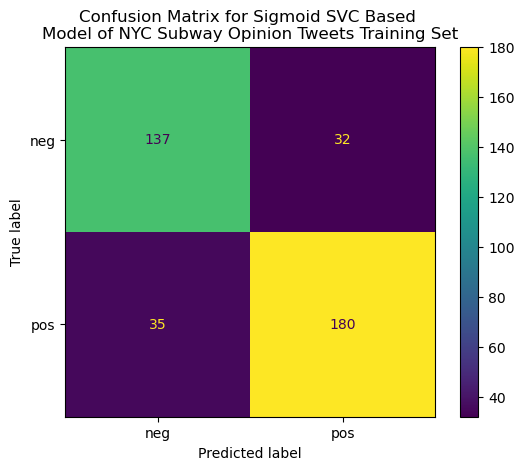

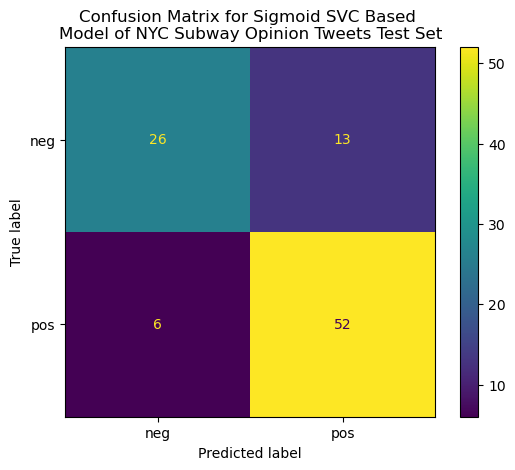

In [10]:
# SVC Model
# Normalize data and fit model
pipeline = make_pipeline(StandardScaler(),SVC(C=10,gamma=0.1,kernel='sigmoid'))

pipeline.fit(x_train,y_train)
yp_train = pipeline.predict(x_train)
yp_test = pipeline.predict(x_test)

# Print classification report
print("CLASSIFICATION REPORT FOR TRAINING SET")
print(classification_report(y_train,yp_train,target_names=["neg","pos"]))
print("CLASSIFICATION REPORT FOR TEST SET")
print(classification_report(y_test,yp_test,target_names=["neg","pos"]))

# Calculate the confusion matrix and classification report for the train and test data.
cm = confusion_matrix(y_train,yp_train)
cm_plot = ConfusionMatrixDisplay(cm,display_labels=labels)
cm_plot.plot()
plt.title("Confusion Matrix for Sigmoid SVC Based \nModel of NYC Subway Opinion Tweets Training Set")
plt.savefig("../../501-project-website/images/SVM-CONFUSION-MX-train-Opinion-Tweets.png")

# Test set
cm = confusion_matrix(y_test,yp_test)
cm_plot = ConfusionMatrixDisplay(cm,display_labels=labels)
cm_plot.plot()
plt.title("Confusion Matrix for Sigmoid SVC Based \nModel of NYC Subway Opinion Tweets Test Set")
plt.savefig("../../501-project-website/images/SVM-CONFUSION-MX-test-Opinion-Tweets.png")

We can see that this model generally does a good job of classifying the sentiments of MTA-related tweets based on their word composition (after removing stop words/standardizing and other feature selection) given by the accuracy, precision, and recall scores occupying the neighborhood in and around 80% across both the training and test set predictions. The confusion matrices back up this assertion given by the number of correclty identified setniments in the main diagonal compared to false negative classifications and false positive classifications. In comparison to the probability based model constructed earlier, it is very clear that the SVC model is a better classifier of these sentiments. In order to improve the fit of this type of model, the hyperparameter tuning could accommodate more options in terms of possible C and gamma values, although such a process would be more computationally intensive and time consuming. The model does not appear to overfitted given by the similar accuracy scores between the predictions regarding the training set and those regarding the test set

## Conclusions

Ultimately, from the creation of the rudimentary probability-based classification model to the hyperparameter tuning and construction of the finalized SVC model, we can see that the SVC model is a vastly superior classification model compared to the probability-based model, given by the decent accuracy, precision, and recall scores along with the accompanying confusion matrices. Thus, this model could be used to easily and quickly predict the sentiment scores of unlabelled tweets. For example, if one was to extract some number of tweets about the MTA from today, their sentiment label could be predicted with reasonably good accuracy using the model constructed above. There is no real indication of overfitting occurring between the training and test data sets, which is evidence to support this model being generalizable to tweets regarding the MTA as a whole, not purely just the data set used to construct the SVC model.

However, this process could be improved in several ways to construct an even more accurate and appropriate model. For one, the hyperparameter search could search over a larger range of potential inputs. This would be a lot more computationally intensive, but may result in a better fitting/more optimal model compared to the one constructed in this section. Additionally, this analysis does not deal with neutral tweets, so further analyses could incorporate those to create a larger classification problem and resulting model. Ultimately, this model serves as a useful means to assessing the positivity and negativity present in tweets regarding the MTA and its various services (such as heavy rail as is the focus of this project as a whole).